# Save and Restore Ranking Agent

Looking for a workaround to `policy_saver()` for ranking agents
* https://github.com/tensorflow/agents/issues/891

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"
VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NAME      = "training_dataset"

REPOSITORY               = "rl-movielens-rec-bandits-v2"

DOCKERNAM

## Imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import time
import functools
import collections
import numpy as np
import pickle as pkl
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar, Iterable, Tuple


# logging
import logging
logging.disable(logging.WARNING)

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf

# from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.environments.ranking_environment import FeedbackModel
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
# from tf_agents.drivers import dynamic_step_driver
# from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

# from tf_agents.bandits.agents import lin_ucb_agent
# from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.bandits.policies import policy_utilities

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory
from tf_agents.bandits.environments import ranking_environment
from tf_agents.bandits.agents import ranking_agent

from tf_agents.utils import nest_utils
from tf_agents.specs import array_spec

from tf_agents.policies import py_tf_eager_policy
from tf_agents.metrics import tf_metrics

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.utils import train_utils
from src.data import data_utils, data_config

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# import tf_agents

# print(f"tf_agents version: {tf_agents.__version__}")
# print(f"tensorflow version: {tf.__version__}")

In [6]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [7]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

## Data

In [8]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

# vocabs
GENERATE_VOCABS = False
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'

# data config
MAX_LIST_LENGTH = 3 # 3 | 5
NUM_EXAMPLES_PER_LIST = MAX_LIST_LENGTH

# SPLIT = "val"
# SPLIT = "listwise-val"
SPLIT = f"listwise-{NUM_EXAMPLES_PER_LIST}n-val"

print(f"SPLIT: {SPLIT}")

! gsutil ls $BUCKET_URI/$DATA_GCS_PREFIX/$SPLIT/

SPLIT: listwise-3n-val
gs://rec-bandits-v2-hybrid-vertex-bucket/data/listwise-3n-val/ml-100k-listwise-3n-val.tfrecord


In [9]:
def get_all_lw_features(MAX_LIST_LENGTH):
    '''
    listwise features
    '''
    feats = {
        'user_id': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        "movie_id": tf.io.FixedLenFeature(dtype=tf.string, shape=(MAX_LIST_LENGTH,)), 
        "movie_genres": tf.io.FixedLenFeature(dtype=tf.int64, shape=(MAX_LIST_LENGTH,)), 
        "user_rating": tf.io.FixedLenFeature(dtype=tf.float32, shape=(MAX_LIST_LENGTH,))
    }
    return feats

def parse_lw_tfrecord(example):
    """
    Reads a serialized example from GCS and converts to tfrecord
    """
    feats = get_all_lw_features(MAX_LIST_LENGTH)
    
    # example = tf.io.parse_single_example(
    example = tf.io.parse_example(example,feats)
    return example

In [10]:
val_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        val_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
val_dataset = tf.data.TFRecordDataset(val_files)
val_dataset = val_dataset.map(parse_lw_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = val_dataset

for example in val_dataset.take(1):
    pprint(example)

{'movie_genres': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 0, 0])>,
 'movie_id': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'94', b'245', b'403'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'346'>,
 'user_rating': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 4., 3.], dtype=float32)>}


### vocabs

In [11]:
data_utils.download_blob(
    project_id = PROJECT_ID,
    bucket_name = BUCKET_NAME, 
    source_blob_name = f"{VOCAB_SUBDIR}/{VOCAB_FILENAME}", 
    destination_file_name= VOCAB_FILENAME
)

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

for key in vocab_dict.keys():
    pprint(key)

Downloaded storage object vocabs/vocab_dict.pkl from bucket rec-bandits-v2-hybrid-vertex-bucket to local file vocab_dict.pkl.
'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


# Ranking Agent

In [12]:
NUM_OOV_BUCKETS       = 2
GLOBAL_EMBEDDING_SIZE = 64 #64
MV_EMBEDDING_SIZE     = 32 #32

BATCH_SIZE            = 5 #128
EVAL_BATCH_SIZE       = 1

NUM_ITEMS             = NUM_EXAMPLES_PER_LIST # 3 | 5 
NUM_SLOTS             = 2

DISTANCE_THRESHOLD    = 0.5

# feedback_model = ranking_environment.FeedbackModel.CASCADING
feedback_model = FeedbackModel.SCORE_VECTOR

print(f"NUM_OOV_BUCKETS    : {NUM_OOV_BUCKETS}")
print(f"GLOBAL_EMB_SIZE    : {GLOBAL_EMBEDDING_SIZE}")
print(f"MV_EMB_SIZE        : {MV_EMBEDDING_SIZE}")
print(f"BATCH_SIZE         : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE    : {EVAL_BATCH_SIZE}")
print(f"NUM_ITEMS          : {NUM_ITEMS}")
print(f"NUM_SLOTS          : {NUM_SLOTS}")
print(f"DISTANCE_THRESHOLD : {DISTANCE_THRESHOLD}")

NUM_OOV_BUCKETS    : 2
GLOBAL_EMB_SIZE    : 64
MV_EMB_SIZE        : 32
BATCH_SIZE         : 5
EVAL_BATCH_SIZE    : 1
NUM_ITEMS          : 3
NUM_SLOTS          : 2
DISTANCE_THRESHOLD : 0.5


## network layers

In [13]:
# ====================================================
# XXX layers
# ====================================================

# user ID
user_id_input_layer = tf.keras.Input(
    name="user_id",
    shape=(1,),
    dtype=tf.string
)
user_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_id'],
)(user_id_input_layer)

user_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_id_lookup)
user_id_embedding = tf.reduce_sum(user_id_embedding, axis=-2)

# to use in _get_features() function
test_user_id_model = tf.keras.Model(inputs=user_id_input_layer, outputs=user_id_embedding)

In [14]:
# ====================================================
# movie layers
# ====================================================

# movie ID
mv_id_input_layer = tf.keras.Input(
    name="movie_id",
    shape=(1,),
    dtype=tf.string
)
mv_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['movie_id'],
)(mv_id_input_layer)
mv_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_id_lookup)
# mv_id_embedding = tf.reduce_sum(mv_id_embedding, axis=-2)

test_mv_id_model = tf.keras.Model(inputs=mv_id_input_layer, outputs=mv_id_embedding)

# genre
mv_genre_input_layer = tf.keras.Input(
    name="movie_genres",
    shape=(1,),
    dtype=tf.float32
)
mv_genre_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_genres'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(mv_genre_input_layer)
mv_genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_genres']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_genre_lookup)
# mv_genre_embedding = tf.reduce_sum(mv_genre_embedding, axis=-2)

test_mv_gen_model = tf.keras.Model(inputs=mv_genre_input_layer, outputs=mv_genre_embedding)

In [15]:
mv_genre_input_layer = tf.keras.Input(
    name="movie_genres",
    shape=(1,),
    dtype=tf.float32
)

mv_genre_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_genres'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(mv_genre_input_layer)

mv_genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_genres']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_genre_lookup)

# mv_genre_embedding = tf.reduce_sum(mv_genre_embedding, axis=-2)

## sampling functions

In [18]:
def _get_per_arm_features(x):
    """
    This function generates a single per-arm observation vector.
    """
    ratings_list = x["user_rating"] #[0]
    indices = tf.argsort(ratings_list, direction="DESCENDING")
    _batch_size = len(ratings_list)
    
    mv_ids = test_mv_id_model(x["movie_id"])
    mv_gens = test_mv_gen_model(x["movie_genres"])
    
    concat_embeddings = tf.concat(
        [mv_ids, mv_gens], axis=-1
    )
    ordered_concat = tf.gather(concat_embeddings, indices, batch_dims=1)
    # feedback = tf.gather_nd(concat_embeddings, indices)
    # print(f"ordered_concat_embeddings: {ordered_concat_embeddings}")
    # ordered_concat = tf.reduce_sum(ordered_concat, axis=0)
    
    slotted_ordered_concat = tf.slice(
        ordered_concat, begin=[0, 0, 0], size=[_batch_size, NUM_SLOTS, MV_EMBEDDING_SIZE * NUM_SLOTS]
    )
    return slotted_ordered_concat


def _get_global_context_features(x):
    """
    This function generates a single global observation vector.
    """
    return test_user_id_model(x['user_id'])

for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

In [19]:
test_arms = _get_per_arm_features(data)
test_globals = _get_global_context_features(data)

PER_ARM_DIM = test_arms.shape[2]
GLOBAL_DIM = test_globals.shape[1]

print(f"PER_ARM_DIM : {PER_ARM_DIM}")
print(f"GLOBAL_DIM  : {GLOBAL_DIM}")

PER_ARM_DIM : 64
GLOBAL_DIM  : 64


## Tensor Specs

In [25]:
observation_spec = {
    'global': tf.TensorSpec([GLOBAL_DIM], tf.float32),
    'per_arm': tf.TensorSpec([NUM_SLOTS, PER_ARM_DIM], tf.float32)
}
action_spec = array_spec.BoundedArraySpec(
    shape=(NUM_SLOTS,),
    dtype=np.int32,
    minimum=0,
    maximum=NUM_ITEMS - 1,
    name='action',
)

if feedback_model == ranking_environment.FeedbackModel.CASCADING:
    reward_spec = {
        'chosen_index': array_spec.BoundedArraySpec(
            shape=[],
            minimum=0,
            maximum=NUM_SLOTS,
            dtype=np.int32,
            name='chosen_index',
        ),
        'chosen_value': array_spec.ArraySpec(
            shape=[], dtype=np.float32, name='chosen_value'
        ),
    }
elif feedback_model == ranking_environment.FeedbackModel.SCORE_VECTOR:
    reward_spec = tf.TensorSpec(
        shape=[NUM_SLOTS], dtype=np.float32, name='score_vector'
    )
else:
    reward_spec = f"Feedback model: {feedback_model}, not implemented"
    
time_step_spec = ts.time_step_spec(
    observation_spec = observation_spec, 
    reward_spec = reward_spec
)

print(f"action_spec rank    : {action_spec.shape}")
print(f"reward_spec rank    : {reward_spec.shape}\n")
time_step_spec

action_spec rank    : (2,)
reward_spec rank    : (2,)



TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(2,), dtype=tf.float32, name='score_vector'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

## ranking config

In [26]:
AGENT_TYPE = "Ranking"
NETWORK_TYPE = "dotproduct"

POLICY_TYPE = ranking_agent.RankingPolicyType.DESCENDING_SCORES 
# COSINE_DISTANCE | NO_PENALTY | DESCENDING_SCORES

PENALTY_MIXTURE = 1.0
LOGITS_TEMPERATURE = 1.0

LEARNING_RATE = 0.005

GLOBAL_LAYERS   = [64, 32, 16]
ARM_LAYERS      = [64, 32, 16]
COMMON_LAYERS   = [16, 8]

HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_items": NUM_ITEMS,
    "num_slots": NUM_SLOTS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LEARNING_RATE,
    "policy_type": POLICY_TYPE,
    "feedback_model" : feedback_model,
    "penalty_mixture": PENALTY_MIXTURE,
    "logits_temperature": LOGITS_TEMPERATURE,
}
pprint(HPARAMS)

{'batch_size': 5,
 'common_layers': [16, 8],
 'eval_batch_size': 1,
 'feedback_model': 2,
 'global_layers': [64, 32, 16],
 'learning_rate': 0.005,
 'logits_temperature': 1.0,
 'model_type': 'Ranking',
 'network_type': 'dotproduct',
 'num_items': 3,
 'num_slots': 2,
 'penalty_mixture': 1.0,
 'per_arm_layers': [64, 32, 16],
 'policy_type': <RankingPolicyType.DESCENDING_SCORES: 3>}


In [27]:
if NETWORK_TYPE == 'commontower':
    scoring_network = global_and_arm_feature_network.create_feed_forward_common_tower_network(
        observation_spec = observation_spec, 
        global_layers = GLOBAL_LAYERS, 
        arm_layers = ARM_LAYERS, 
        common_layers = COMMON_LAYERS,
        # output_dim = output_dim,
    )
    
elif NETWORK_TYPE == 'dotproduct':
    scoring_network = global_and_arm_feature_network.create_feed_forward_dot_product_network(
        observation_spec = observation_spec, 
        global_layers = GLOBAL_LAYERS, 
        arm_layers = ARM_LAYERS
    )
    
if NETWORK_TYPE:
    print(f"Network: {scoring_network.name}")

Network: GlobalAndArmDotProductNetwork


## Define agent

In [28]:
rank_agent = ranking_agent.RankingAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    scoring_network=scoring_network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=HPARAMS['learning_rate']),
    feedback_model=ranking_agent.FeedbackModel.SCORE_VECTOR,
    policy_type=HPARAMS['policy_type'],
    logits_temperature=HPARAMS['logits_temperature'],
    penalty_mixture_coefficient=HPARAMS['penalty_mixture'],
    summarize_grads_and_vars=True
)

global_step = tf.compat.v1.train.get_or_create_global_step()

rank_agent.initialize()
print(f'agent: {rank_agent.name}')
print(f'agent: {rank_agent.policy.name}')

agent: ranking_agent
agent: descending_score_ranking_policy


In [29]:
# rank_agent.policy
# rank_agent.action_spec
# rank_agent.training_data_spec.observation
# rank_agent.policy.time_step_spec
# rank_agent.policy.trajectory_spec

# Trainer

## helper functions

In [30]:
def _get_ranking_rewards_sv(x):
    """Calculates reward for the actions."""

    ratings_list = x["user_rating"] #[0]
    indices = tf.argsort(ratings_list, direction="DESCENDING")
    feedback = tf.gather(ratings_list, indices, batch_dims=-1)
    top_n_ratings = tf.slice(feedback, begin=[0, 0], size=[-1, HPARAMS['num_slots']])
    
    return top_n_ratings

def _rank_trajectory_fn(element):
    """Converts a dataset element into a trajectory."""
    global_features = _get_global_context_features(element)
    arm_features = _get_per_arm_features(element)
    
    # obs spec
    observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            train_utils._add_outer_dimension(global_features),
            # global_features,
        bandit_spec_utils.PER_ARM_FEATURE_KEY: 
            train_utils._add_outer_dimension(arm_features)
            # arm_features
    }
    ranking_rewards = _get_ranking_rewards_sv(element)
    action=tf.zeros_like(HPARAMS['num_slots'], dtype=tf.int32)
    discount=tf.zeros_like(HPARAMS['num_slots'], dtype=tf.int32)
    
    return trajectory.single_step(
        observation=observation,
        action=action,
        policy_info=(),
        reward=ranking_rewards,
        discount=discount
    )

In [31]:
for x in train_dataset.batch(HPARAMS['batch_size']).take(1):
    test_traj = _rank_trajectory_fn(x)
    
print(f"test_traj.observation.shape: {test_traj.observation['global'].shape}")
print(f"test_traj.observation.shape: {test_traj.observation['per_arm'].shape}")
print(f"test_traj.discount.shape   : {test_traj.discount.shape}") 

expected_num_actions = action_spec.maximum - action_spec.minimum + 1
print(f"expected_num_actions: {expected_num_actions}")

predicted_rewards_mean = tensor_spec.TensorSpec([expected_num_actions])
print(f"predicted_rewards_mean: {predicted_rewards_mean}")

test_traj.observation.shape: (5, 1, 64)
test_traj.observation.shape: (5, 1, 2, 64)
test_traj.discount.shape   : ()
expected_num_actions: 3
predicted_rewards_mean: TensorSpec(shape=(3,), dtype=tf.float32, name=None)


## Vertex Experiment

In [32]:
EXPERIMENT_NAME   = 'rank-saver-v1'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : rank-saver-v1
RUN_NAME          : run-20250124-211821

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/run-20250124-211821
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/run-20250124-211821/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/run-20250124-211821/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/run-20250124-211821/artifacts


In [33]:
# ====================================================
# TB summary writer
# ====================================================
train_summary_writer = tf.compat.v2.summary.create_file_writer(
    f"{LOG_DIR}", flush_millis=10 * 1000
)
# ====================================================
# metrics
# ====================================================
step_metric = tf_metrics.EnvironmentSteps()

if feedback_model == ranking_environment.FeedbackModel.SCORE_VECTOR:
    reward_metric = tf_metrics.AverageReturnMetric(
        batch_size=HPARAMS['batch_size'],
        buffer_size=20
    )
else:
    reward_metric = tf_metrics.AverageReturnMultiMetric(
        reward_spec=environment.reward_spec(),
        batch_size=HPARAMS['batch_size'],
        buffer_size=20
    )
metrics = [reward_metric]

pprint(f"metrics: {metrics}\n")
# ====================================================
# get checkpoint manager
# ====================================================
print(f"setting checkpoint_manager: {CHECKPT_DIR}\n")

checkpoint_manager = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHECKPT_DIR, 
    agent=rank_agent, 
    metrics=metrics, 
    step_metric=global_step # step_metric
)

('metrics: [<tf_agents.metrics.tf_metrics.AverageReturnMetric object at '
 '0x7f9770230a60>]\n')
setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/chkpoint

Did not find a pre-existing checkpoint. Starting from scratch.


## Train config

In [34]:
TRAIN_DATA_SIZE = 900
NUM_TRAIN_STEPS = 50
EVAL_DATA_SIZE  = 900
NUM_EVAL_STEPS  = 100
CHKPT_INTERVAL  = NUM_TRAIN_STEPS - 1 # // 5
LOG_INTERVAL    = 10
# EVAL_INTERVAL = NUM_TRAIN_STEPS // 2

EVAL_LOOP_BATCH_SIZE = 1

print(f"TRAIN_DATA_SIZE : {TRAIN_DATA_SIZE}")
print(f"NUM_TRAIN_STEPS : {NUM_TRAIN_STEPS}")
print(f"EVAL_DATA_SIZE : {EVAL_DATA_SIZE}")
print(f"NUM_EVAL_STEPS : {NUM_EVAL_STEPS}")
print(f"CHKPT_INTERVAL: {CHKPT_INTERVAL}")
print(f"LOG_INTERVAL : {LOG_INTERVAL}")

TRAIN_DATA_SIZE : 900
NUM_TRAIN_STEPS : 50
EVAL_DATA_SIZE : 900
NUM_EVAL_STEPS : 100
CHKPT_INTERVAL: 49
LOG_INTERVAL : 10


In [35]:
train_ds_iterator = iter(train_dataset.batch(HPARAMS['batch_size']))
eval_ds = val_dataset.batch(HPARAMS["eval_batch_size"])

if NUM_EVAL_STEPS > 0:
    eval_ds = eval_ds.take(NUM_EVAL_STEPS)

# ====================================================
# train setp function
# ====================================================
@tf.function
def _train_step_fn():

    data = next(train_ds_iterator)
    trajectories = _rank_trajectory_fn(data)
    loss = rank_agent.train(experience=trajectories)

    return loss

In [36]:
list_o_loss = []

rank_agent.train_step_counter.assign(0)

print(f"starting train loop...")
start_time = time.time()

for i in range(NUM_TRAIN_STEPS):
    
    with train_summary_writer.as_default():

        step = rank_agent.train_step_counter.numpy()
        
        loss = _train_step_fn()
        list_o_loss.append(loss.loss.numpy())
        
        train_utils._export_metrics_and_summaries(
            step=i, 
            metrics=metrics
        )
        
        # print step loss
        if step % LOG_INTERVAL == 0:
            print(
                'step = {0}: train loss = {1}'.format(
                    step, round(loss.loss.numpy(), 2)
                )
            )
            
checkpoint_manager.save(global_step)
print(f"saved to checkpoint_manager: {CHECKPT_DIR}")
runtime_mins = int((time.time() - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

starting train loop...
step = 0: train loss = 17.479999542236328
step = 10: train loss = 7.28000020980835
step = 20: train loss = 1.4299999475479126
step = 30: train loss = 1.659999966621399
step = 40: train loss = 1.1100000143051147
saved to checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/chkpoint
train runtime_mins: 3


In [37]:
! gsutil ls $CHECKPT_DIR

gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/chkpoint/
gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/chkpoint/checkpoint
gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/chkpoint/ckpt-50.data-00000-of-00001
gs://rec-bandits-v2-hybrid-vertex-bucket/rank-saver-v1/chkpoint/ckpt-50.index


In [38]:
### eval

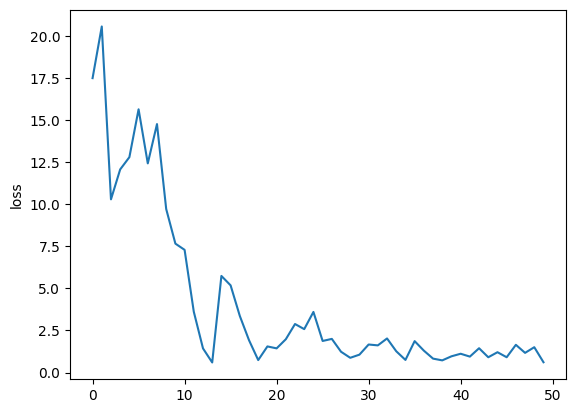

In [39]:
import matplotlib.pyplot as plt

plt.plot(list_o_loss)
# plt.ylim([0, 10])
plt.ylabel('loss')
plt.show()

In [40]:
# ! gsutil ls $LOG_DIR

In [41]:
# %load_ext tensorboard
# %reload_ext tensorboard

In [42]:
# %tensorboard --logdir=$LOG_DIR

# Restore Ranking Agent from checkpoint?

restoring from an existing checkpoint dir, such as:

```
├── chkpt_dir
│   ├── checkpoint
│   │   ├── checkpoint
│   │   ├── ckpt-250.data-00000-of-00001
│   │   ├── ckpt-250.index
│   │   ├── ckpt-50.data-00000-of-00001
│   │   └── ckpt-50.index
```

**TODO**
* may need to figure out variable states for the in-notebook example (e.g., loading two agents might OOM the GPU)

In [43]:
rank_agent_v2 = ranking_agent.RankingAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    scoring_network=scoring_network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=HPARAMS['learning_rate']),
    feedback_model=ranking_agent.FeedbackModel.SCORE_VECTOR, # FeedbackModel.SCORE_VECTOR, # feedback_model,
    policy_type=HPARAMS['policy_type'],
    logits_temperature=HPARAMS['logits_temperature'],
    penalty_mixture_coefficient=HPARAMS['penalty_mixture'],
    summarize_grads_and_vars=True
)

rank_agent_v2.initialize()

print(f'rank_agent_v2    : {rank_agent_v2.name}')
print(f'agent train step : {rank_agent_v2.train_step_counter.numpy()}')

rank_agent_v2    : ranking_agent
agent train step : 50


In [46]:
restored_ranking_ckpt = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHECKPT_DIR, 
    agent=rank_agent_v2, 
    metrics=metrics, 
    step_metric=global_step
)

### Load Eager Policy

In [ ]:
restored_ranking_agent_v2 = py_tf_eager_policy.PyTFEagerPolicy(rank_agent_v2.policy, use_tf_function=True)
restored_ranking_agent_v2

### infer eager

In [60]:
INFER_SIZE = 1
SKIP_NUM = 25

for x in eval_ds.skip(SKIP_NUM).take(INFER_SIZE):
    
    # global context features
    global_features = _get_global_context_features(x)
    global_features = tf.reshape(global_features, [GLOBAL_DIM]) # flatten
    arm_features = _get_per_arm_features(x)
    arm_feat_infer = tf.reshape(
        arm_features, [ HPARAMS['num_slots'], HPARAMS['eval_batch_size'], PER_ARM_DIM ]
    )
    arm_feat_infer = train_utils._remove_outer_dimension(arm_feat_infer)
    observation = {'global': global_features, 'per_arm': arm_feat_infer}
    
    ranking_rewards = _get_ranking_rewards_sv(x)
    
    action = np.zeros((HPARAMS['num_slots']), dtype=np.int32)
    discount = np.zeros((HPARAMS['num_slots']), dtype=np.float32)
    
    infer_step = ts.TimeStep(
        step_type = tf.constant(
            ts.StepType.FIRST, 
            dtype=tf.int32, 
            shape=[],
            name='step_type'
        ),
        reward = ranking_rewards,
        discount = tf.constant(
            1.0, dtype=tf.float32, shape=[], name='discount'
        ),
        observation = observation
    )
    prediction = restored_ranking_agent_v2.action(infer_step)
    
prediction

PolicyStep(action=array([1, 0], dtype=int32), state=(), info=PolicyInfo(log_probability=(), predicted_rewards_mean=array([4.5277176, 5.1859093], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()))

In [61]:
prediction.action

array([1, 0], dtype=int32)

In [62]:
prediction.info.predicted_rewards_mean

array([4.5277176, 5.1859093], dtype=float32)

In [63]:
restart_prediction = restored_ranking_agent_v2.action(
    ts.restart(observation, batch_size=HPARAMS['eval_batch_size']), ()
)
restart_prediction

PolicyStep(action=array([1, 0], dtype=int32), state=(), info=PolicyInfo(log_probability=(), predicted_rewards_mean=array([4.5277176, 5.1859093], dtype=float32), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()))